#  Employee’s Performance for HR Analytics (Unsupervised Learning)

**📊 Dataset:** `Uncleaned_employees_final_dataset (1).csv`  
**📚 Source:** [Kaggle – HR Analytics: Employee Performance Dataset](https://www.kaggle.com/)  



### 🎯 Goal
Use **unsupervised learning (clustering)** to discover hidden employee groups based on demographics, performance, and experience.  
This helps HR understand workforce patterns and improve engagement and retention strategies.



### 📈 Description
By analyzing features like:
- `age`, `education`, `department`, `length_of_service`,  
- `no_of_trainings`, `previous_year_rating`, `KPIs_met_more_than_80`,  
- `awards_won`, and `avg_training_score`,  

the project identifies meaningful employee clusters to support **data-driven HR decisions**.


## Phase 0: Import Libraries & Load Data

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Dimensionality Reduction
from sklearn.decomposition import PCA

# Clustering models
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

# Evaluation metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Outlier detection
from sklearn.ensemble import IsolationForest

# Neighbors (for DBSCAN eps)
from sklearn.neighbors import NearestNeighbors

# Dimensionality visualization
from sklearn.manifold import TSNE

# VIF calculation
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Model saving
import joblib
import os


In [2]:
# Load the dataset
df = pd.read_csv(r"C:\Users\Msi\OneDrive\Documents\ML\Employee-Segmentation-Clustering\Data\Uncleaned_employees_final_dataset (1).csv")

## Phase 1: Data Overview

In [3]:
# Dataset shape
print("Dataset Shape:", df.shape)

Dataset Shape: (17417, 13)


In [4]:
# Quick look at the data
display(df.head())
display(df.sample(5))

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_more_than_80,awards_won,avg_training_score
0,8724,Technology,region_26,Bachelors,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelors,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelors,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelors,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelors,m,sourcing,1,30,4.0,7,0,0,61


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_more_than_80,awards_won,avg_training_score
15894,37955,Operations,region_27,Bachelors,m,sourcing,1,33,3.0,7,0,0,73
10321,53720,Legal,region_7,Bachelors,m,other,1,32,3.0,5,0,0,57
15485,20300,Operations,region_2,Masters & above,m,other,1,40,3.0,6,0,0,62
4507,53063,Sales & Marketing,region_6,Bachelors,m,other,1,25,1.0,2,0,0,52
8342,6650,Operations,region_23,Bachelors,f,other,2,31,3.0,8,0,0,59


In [5]:
# Info
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17417 entries, 0 to 17416
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   employee_id            17417 non-null  int64  
 1   department             17417 non-null  object 
 2   region                 17417 non-null  object 
 3   education              16646 non-null  object 
 4   gender                 17417 non-null  object 
 5   recruitment_channel    17417 non-null  object 
 6   no_of_trainings        17417 non-null  int64  
 7   age                    17417 non-null  int64  
 8   previous_year_rating   16054 non-null  float64
 9   length_of_service      17417 non-null  int64  
 10  KPIs_met_more_than_80  17417 non-null  int64  
 11  awards_won             17417 non-null  int64  
 12  avg_training_score     17417 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 1.7+ MB


In [6]:
# Numerical summary
print("\nNumerical Summary:")
display(df.describe().T)


Numerical Summary:


,count,mean,std,min,25%,50%,75%,max
employee_id,17417.0,39083.491129,22707.024087,3.0,19281.0,39122.0,58838.0,78295.0
no_of_trainings,17417.0,1.250732,0.595692,1.0,1.0,1.0,1.0,9.0
age,17417.0,34.807774,7.694046,20.0,29.0,33.0,39.0,60.0
previous_year_rating,16054.0,3.345459,1.265386,1.0,3.0,3.0,4.0,5.0
length_of_service,17417.0,5.801860,4.175533,1.0,3.0,5.0,7.0,34.0
KPIs_met_more_than_80,17417.0,0.358845,0.479675,0.0,0.0,0.0,1.0,1.0
awards_won,17417.0,0.023368,0.151074,0.0,0.0,0.0,0.0,1.0
avg_training_score,17417.0,63.176322,13.418179,39.0,51.0,60.0,75.0,99.0


In [7]:
# Categorical summary
print("\nCategorical Summary:")
display(df.describe(include='object').T)


Categorical Summary:


,count,unique,top,freq
department,17417,9,Sales & Marketing,5458
region,17417,34,region_2,3918
education,16646,3,Bachelors,11519
gender,17417,2,m,12314
recruitment_channel,17417,3,other,9751


## Phase 2: Data Understanding

In [8]:
# Identify numerical and categorical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns
print("\nNumerical Columns:", num_cols.tolist())
print("Categorical Columns:", cat_cols.tolist())


Numerical Columns: ['employee_id', 'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'KPIs_met_more_than_80', 'awards_won', 'avg_training_score']
Categorical Columns: ['department', 'region', 'education', 'gender', 'recruitment_channel']


In [9]:
# Count unique values
print("\nUnique Values per Column:")
display(df.nunique().to_frame('Unique Values').T)


Unique Values per Column:


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_more_than_80,awards_won,avg_training_score
Unique Values,17414,9,34,3,2,3,9,41,5,34,2,2,61


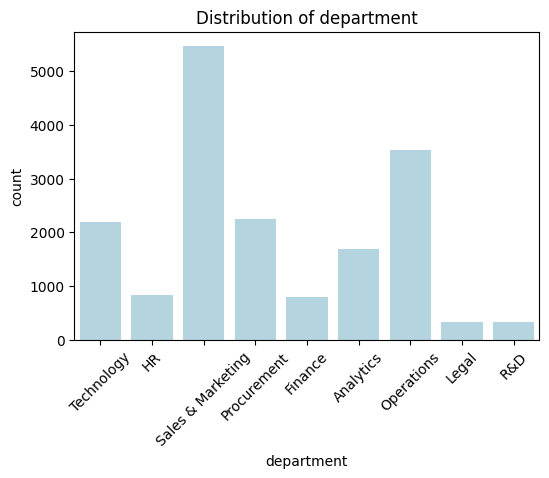

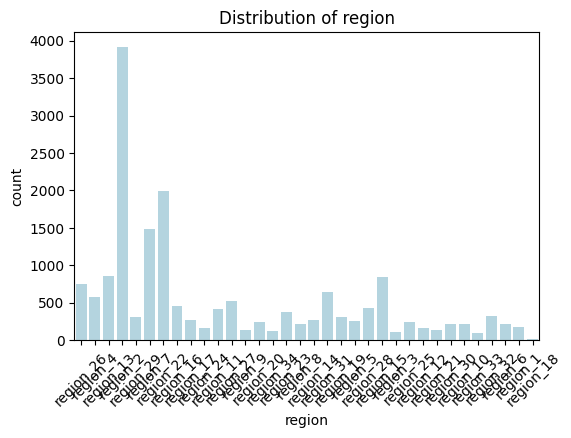

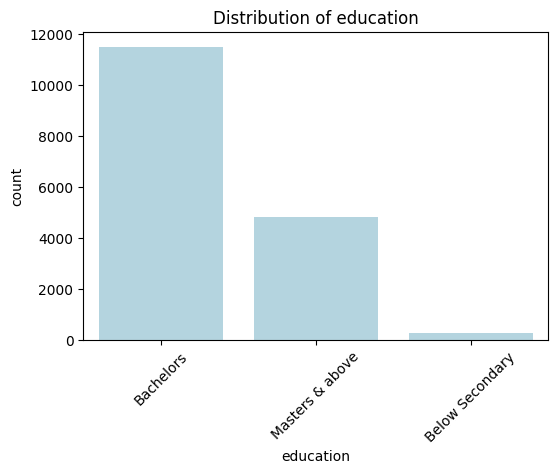

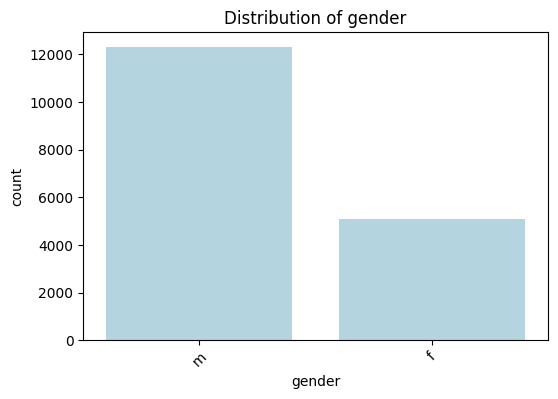

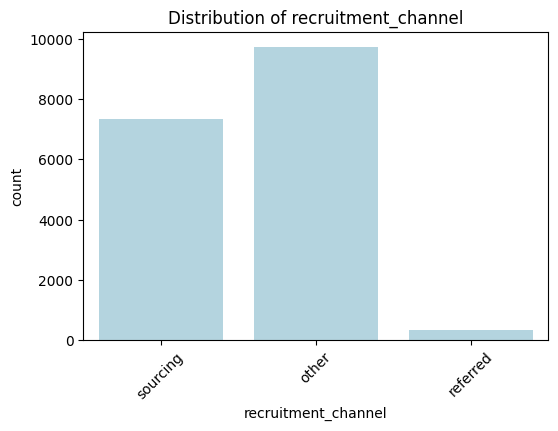

In [10]:
# Visualize first few categorical columns
for col in cat_cols[:5]:  
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=df, color='lightblue')  
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()

In [11]:
# Display the number of numerical and categorical columns
print(f"✅ Total Numerical Columns: {len(num_cols)}")
print(f"✅ Total Categorical Columns: {len(cat_cols)}")

✅ Total Numerical Columns: 8
✅ Total Categorical Columns: 5


## Phase 3: Data Cleaning

In [12]:
# Check for Missing Values
print("Missing Values per Column:")
print(df.isna().sum())


Missing Values per Column:
employee_id                 0
department                  0
region                      0
education                 771
gender                      0
recruitment_channel         0
no_of_trainings             0
age                         0
previous_year_rating     1363
length_of_service           0
KPIs_met_more_than_80       0
awards_won                  0
avg_training_score          0
dtype: int64


In [13]:
# handle missing values
df.dropna(inplace=True)

In [14]:
# Verify that missing values are handled
print("✅ Missing values after filling:")
print(df.isnull().sum())

✅ Missing values after filling:
employee_id              0
department               0
region                   0
education                0
gender                   0
recruitment_channel      0
no_of_trainings          0
age                      0
previous_year_rating     0
length_of_service        0
KPIs_met_more_than_80    0
awards_won               0
avg_training_score       0
dtype: int64


In [15]:
# Check for Duplicates
print("\n🔹 Number of duplicate rows:")
df.duplicated().sum()


🔹 Number of duplicate rows:


np.int64(2)

In [16]:
#  Remove duplicates
df.drop_duplicates(inplace=True)

In [17]:
# drop identifier column
df.drop(columns=['employee_id'], inplace=True)


## Phase 4: EDA

In [18]:
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

In [19]:
# Set plot style and palette
plt.style.use("fivethirtyeight")
sns.set_palette("Set2")

### Univariate Analysis

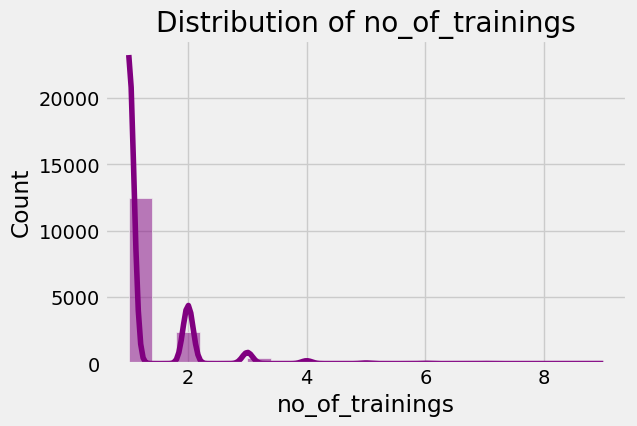

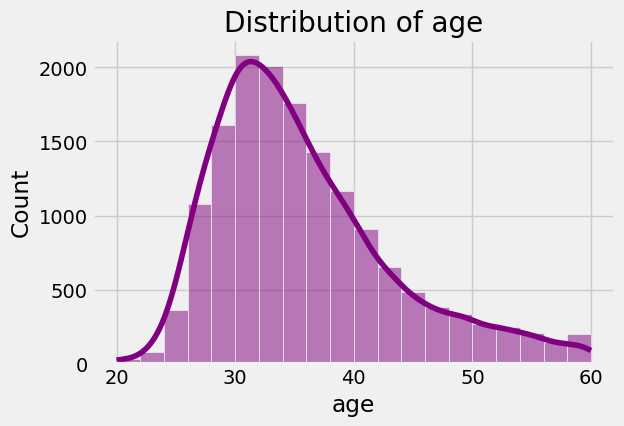

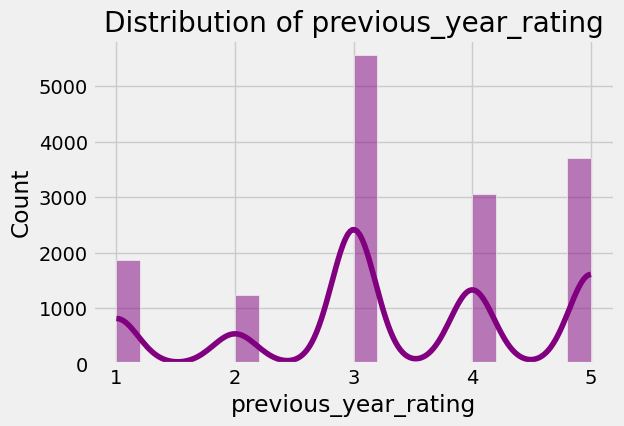

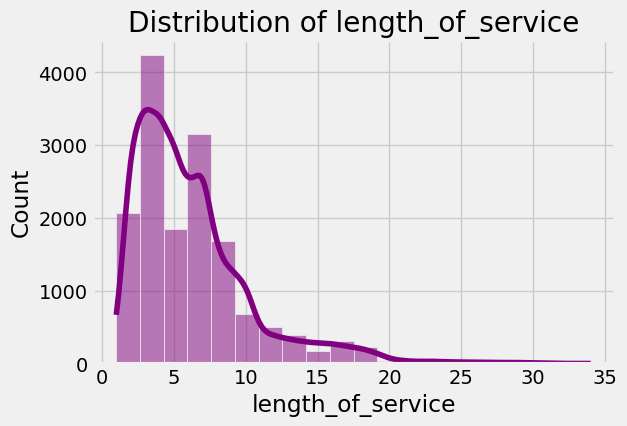

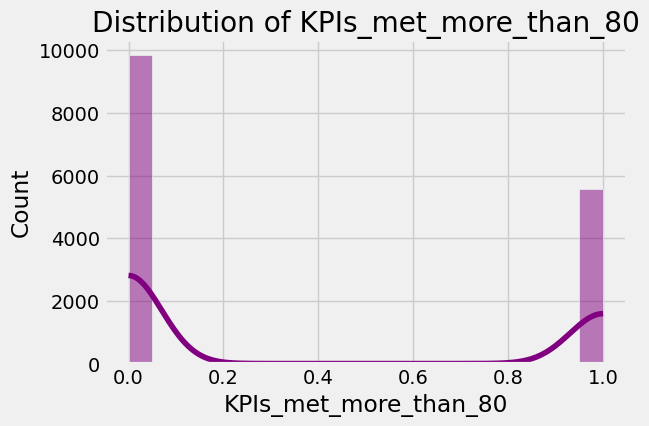

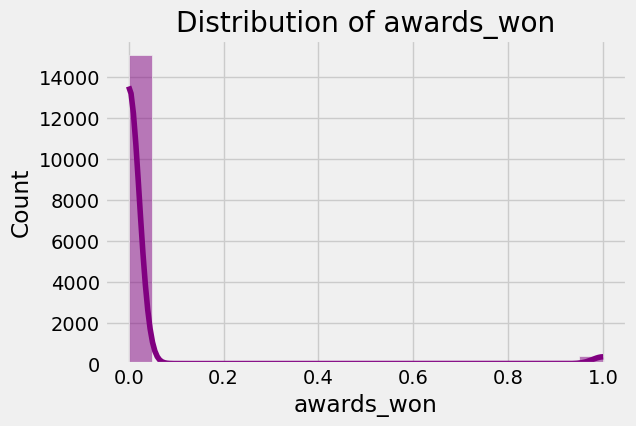

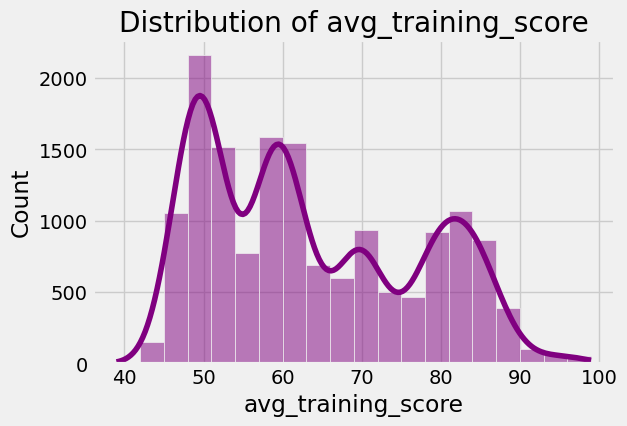

In [20]:
# Univariate - numerical
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=20, color='purple')
    plt.title(f"Distribution of {col}")
    plt.show()

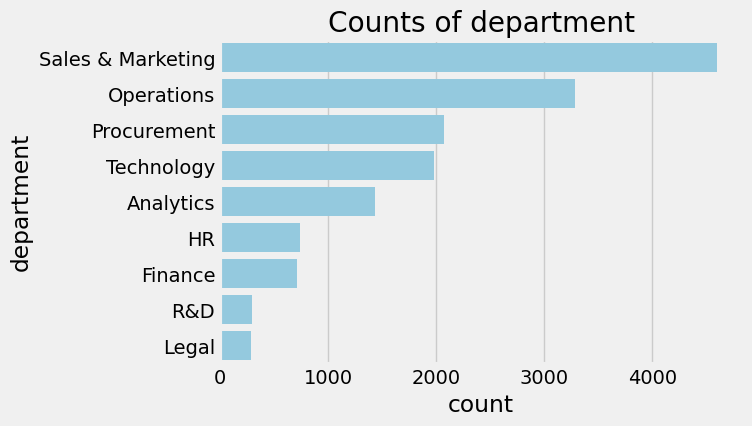

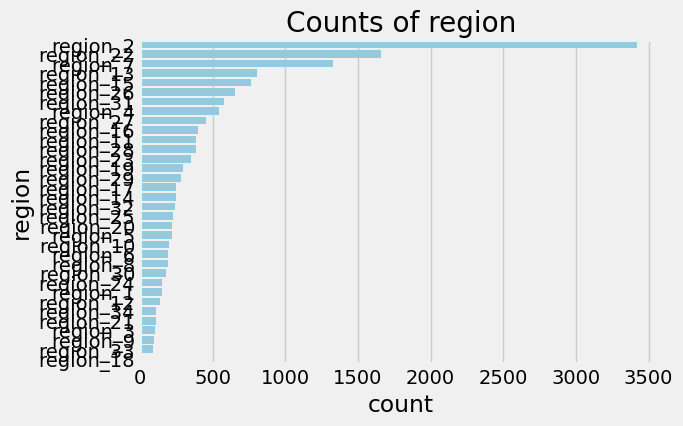

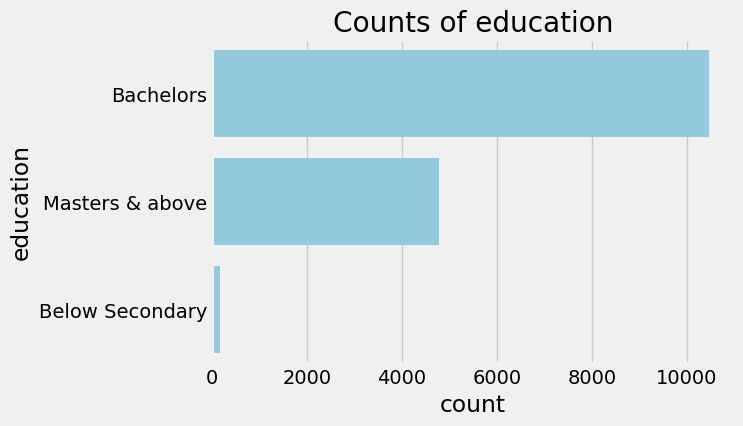

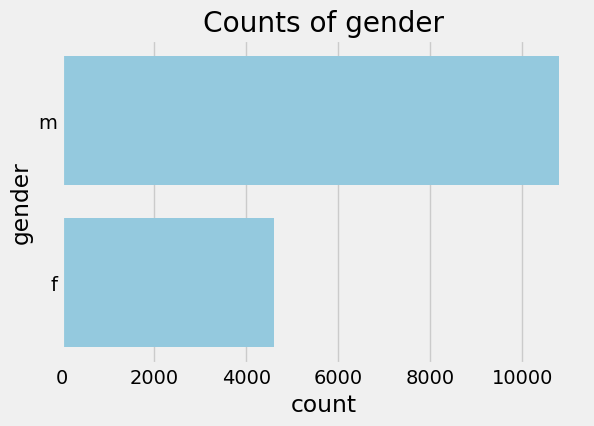

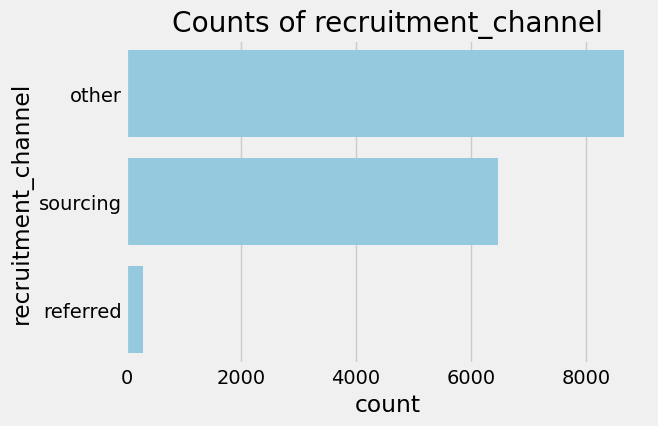

In [21]:
# Univariate - categorical
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index, color='skyblue')
    plt.title(f"Counts of {col}")
    plt.show()

### Bivariate Analysis

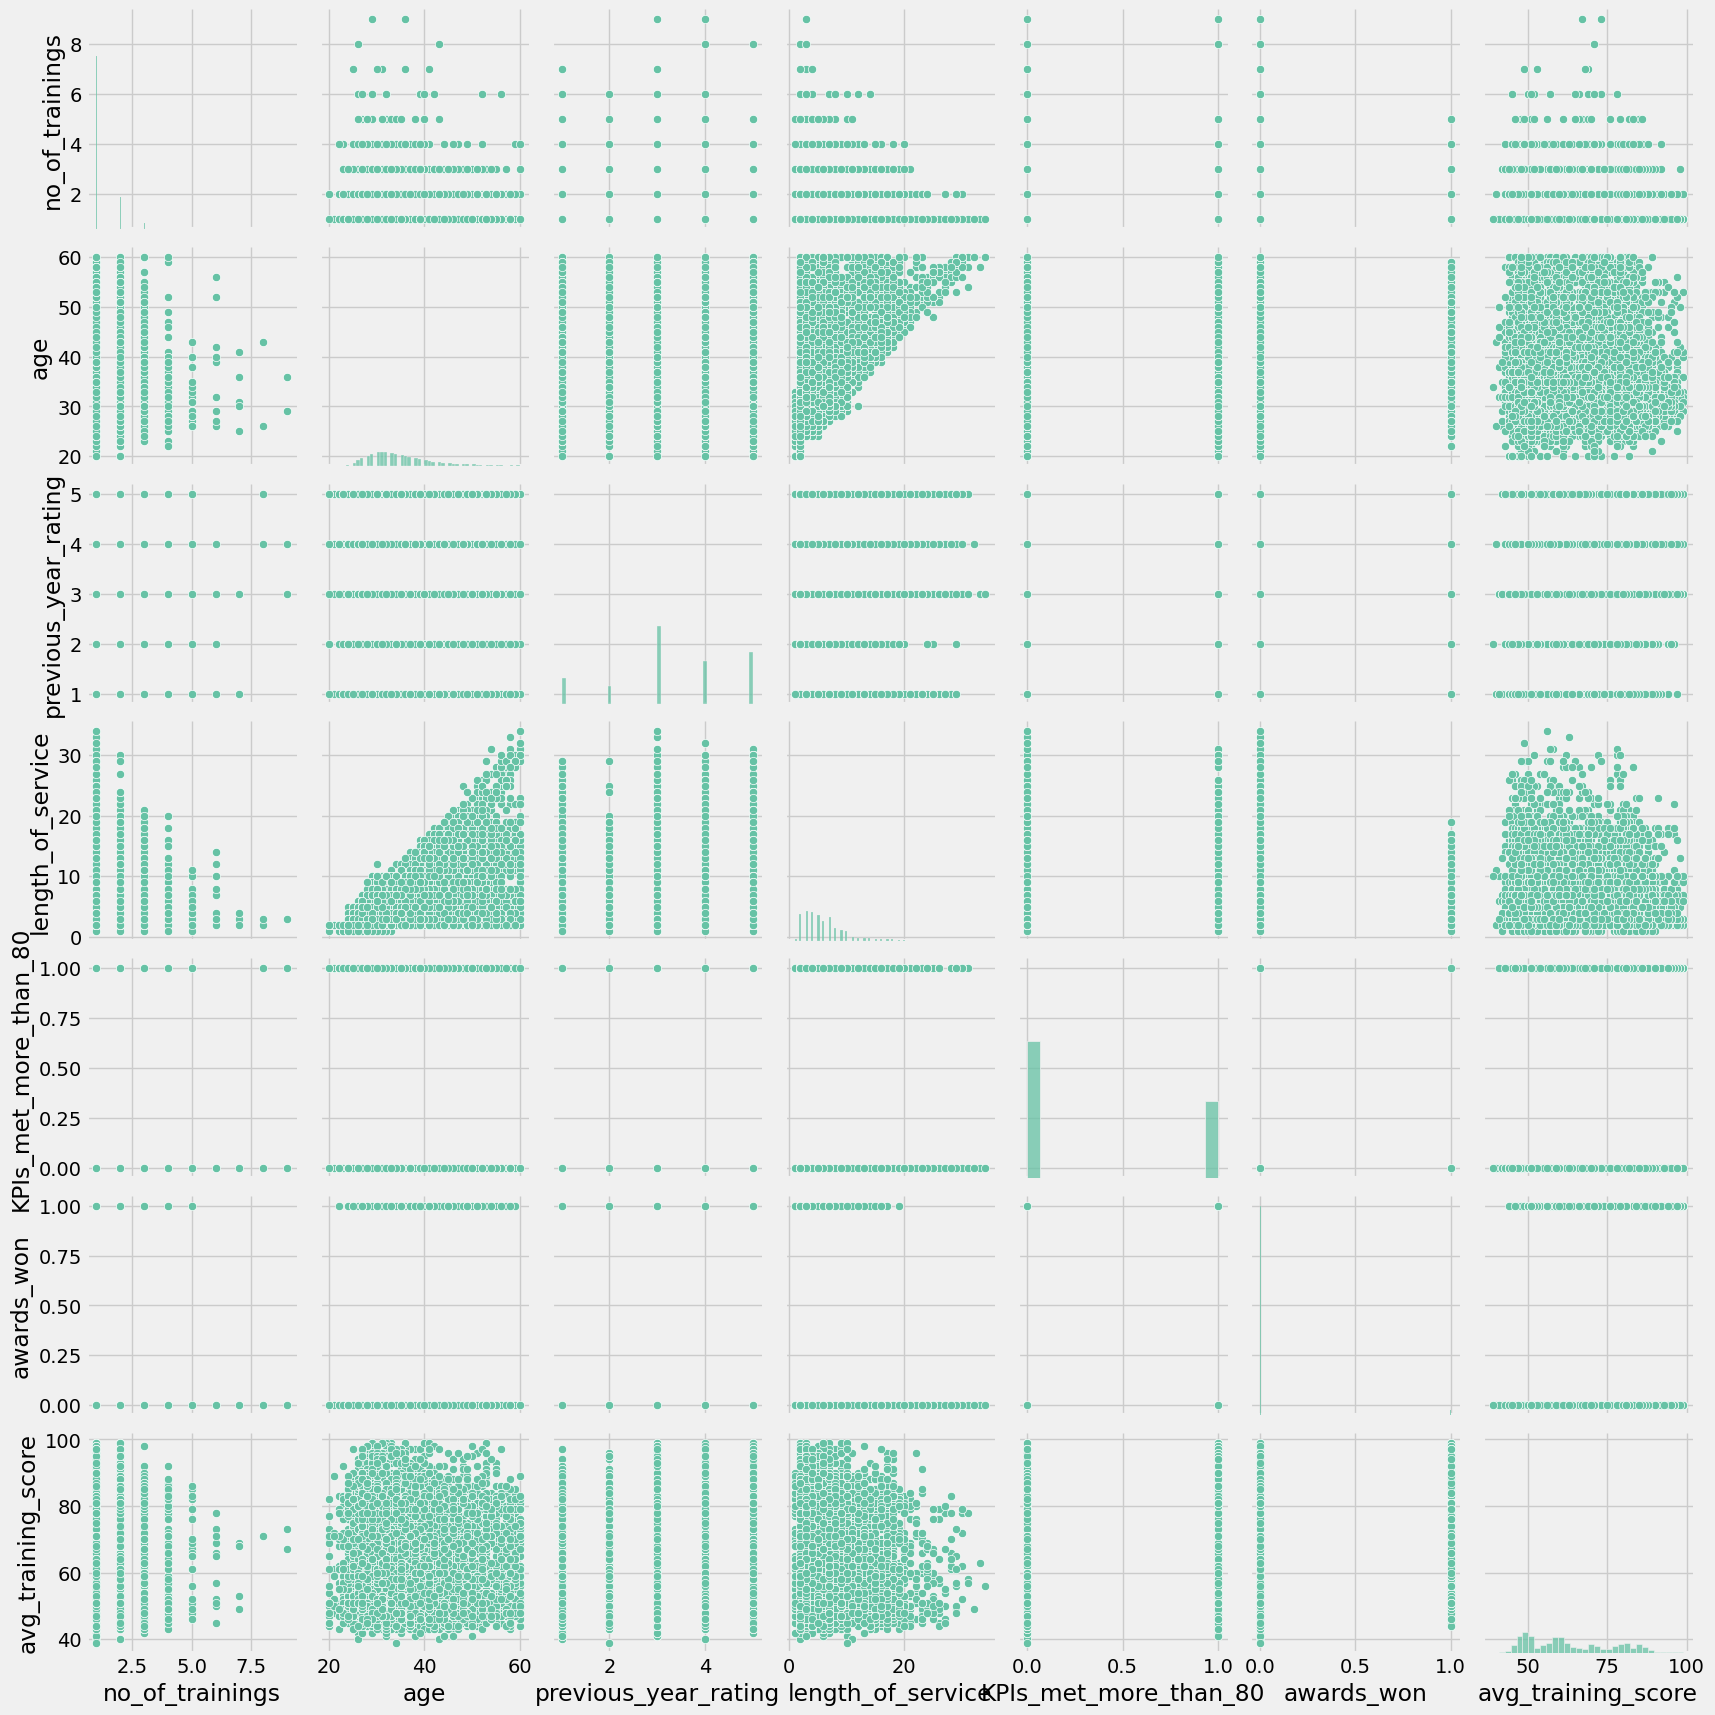

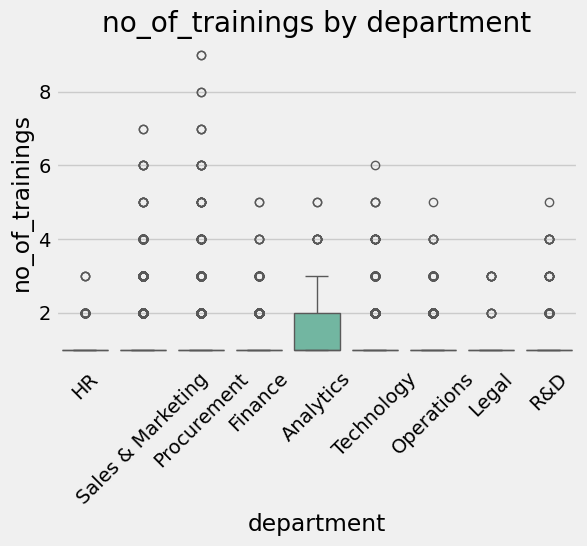

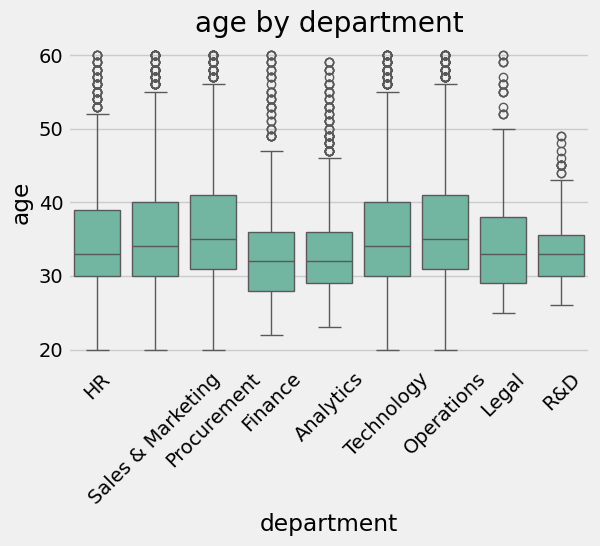

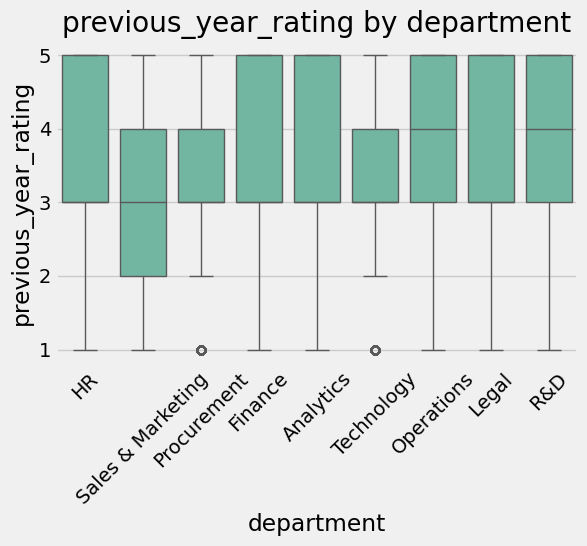

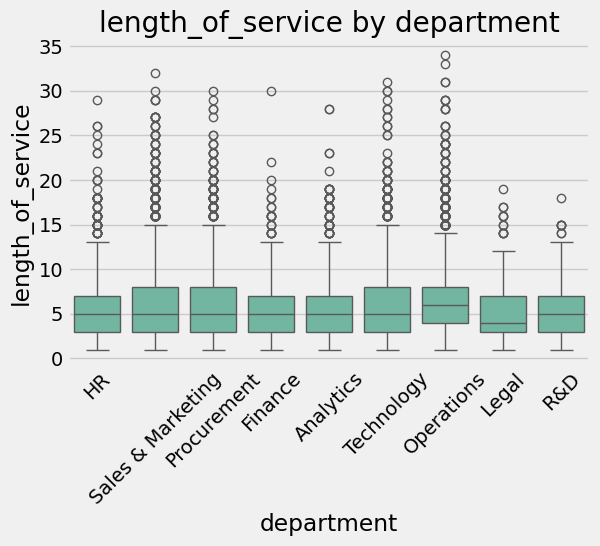

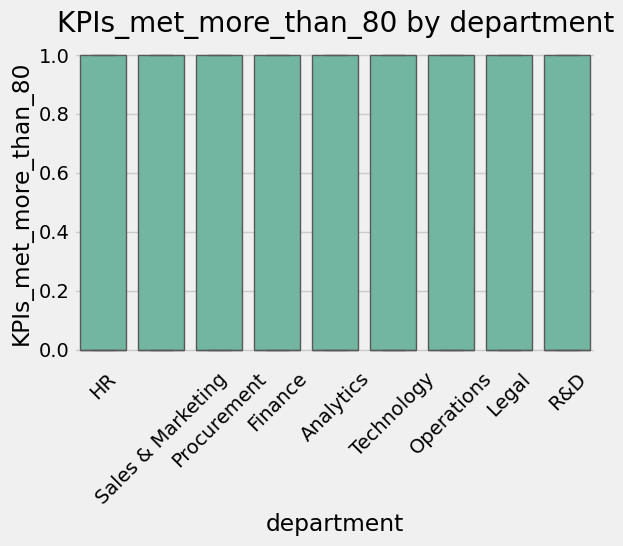

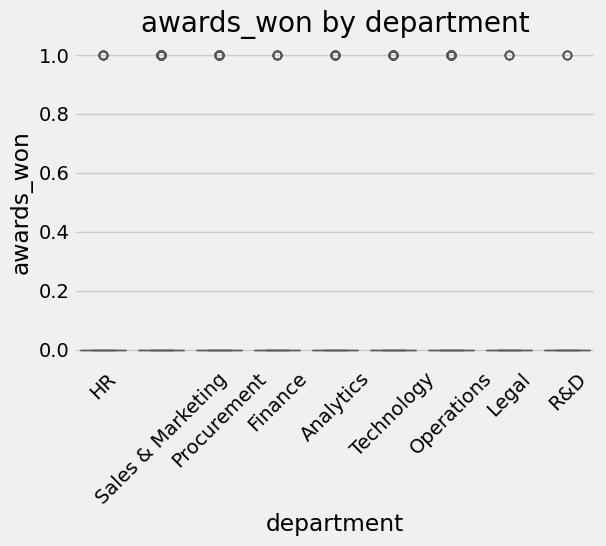

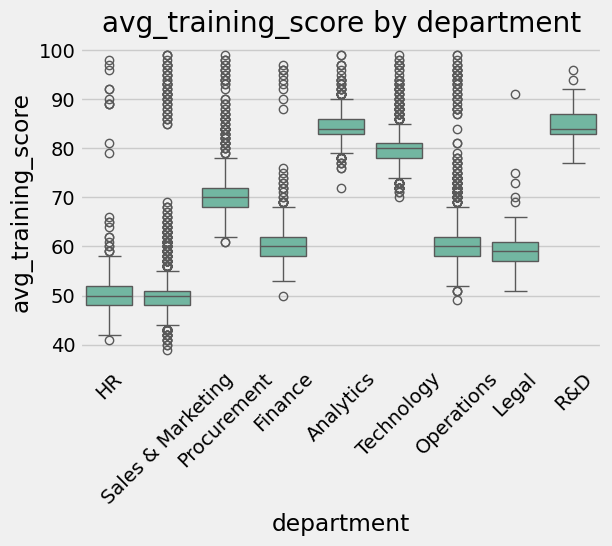

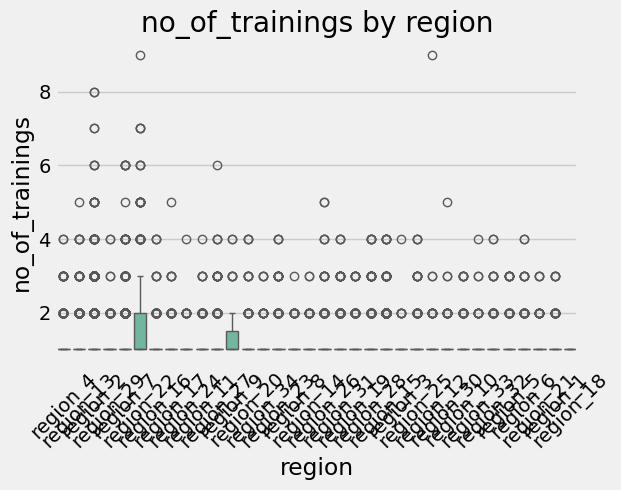

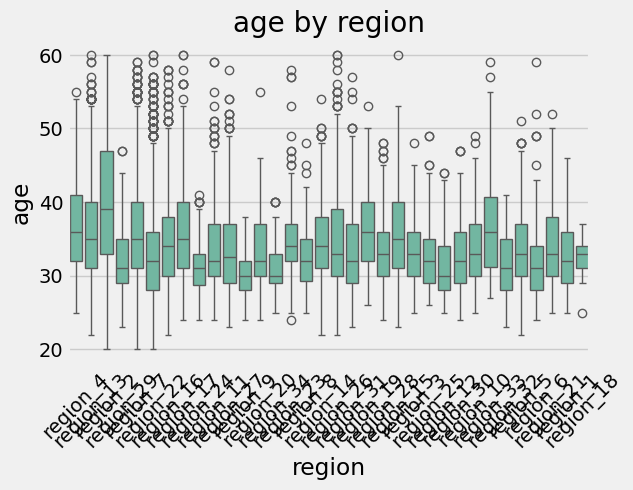

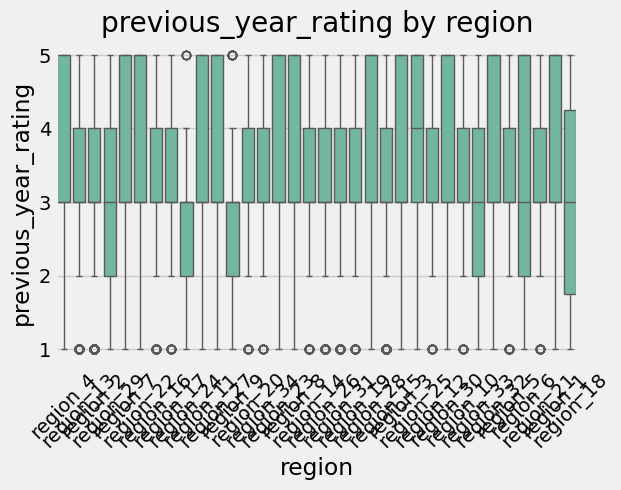

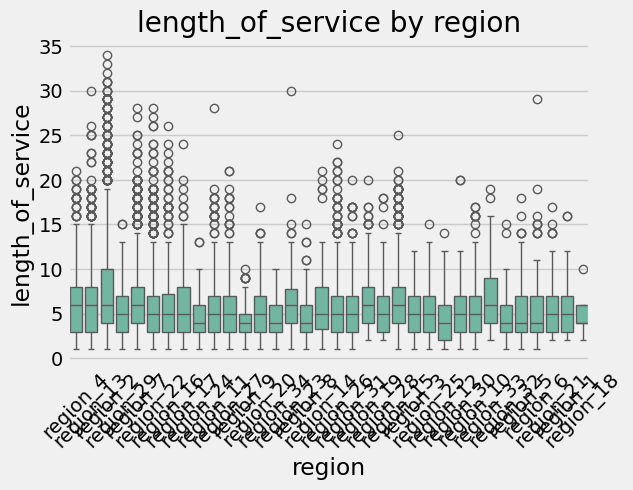

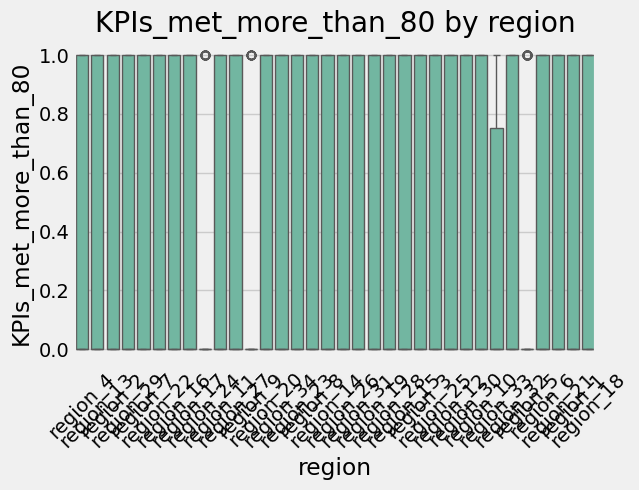

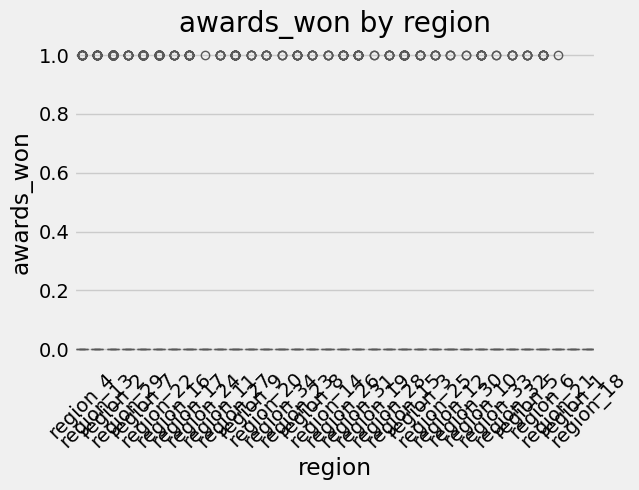

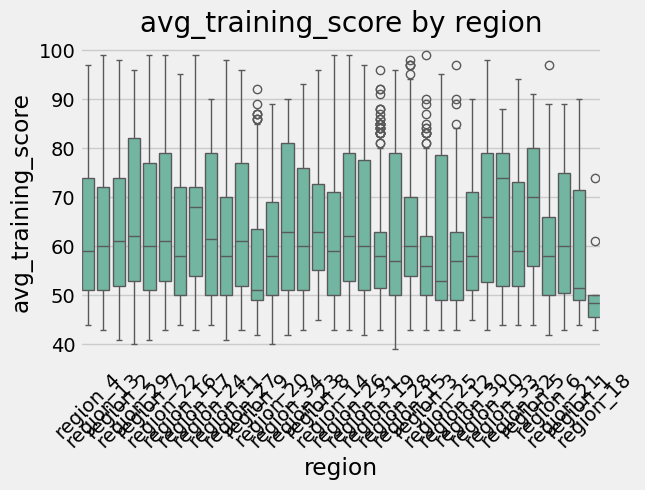

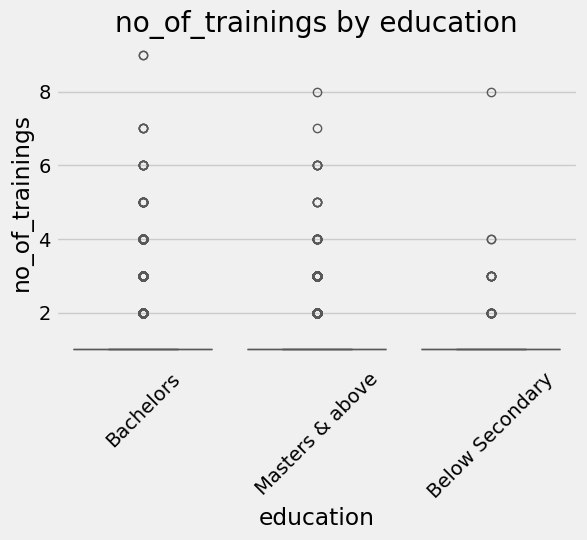

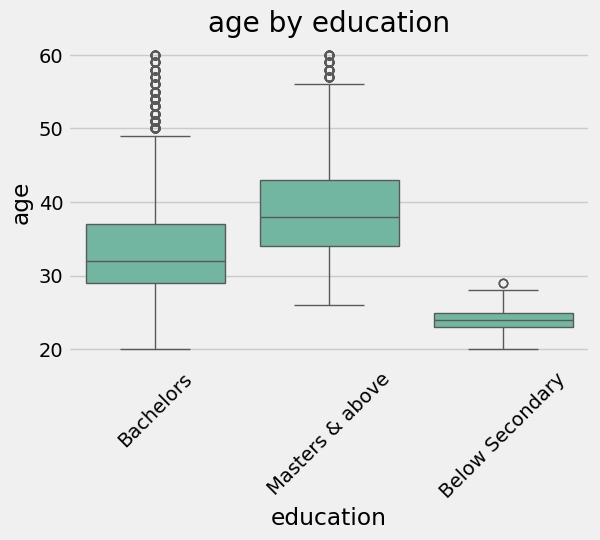

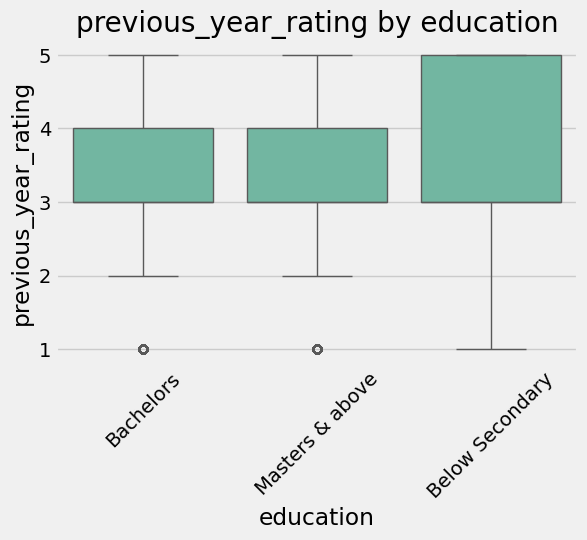

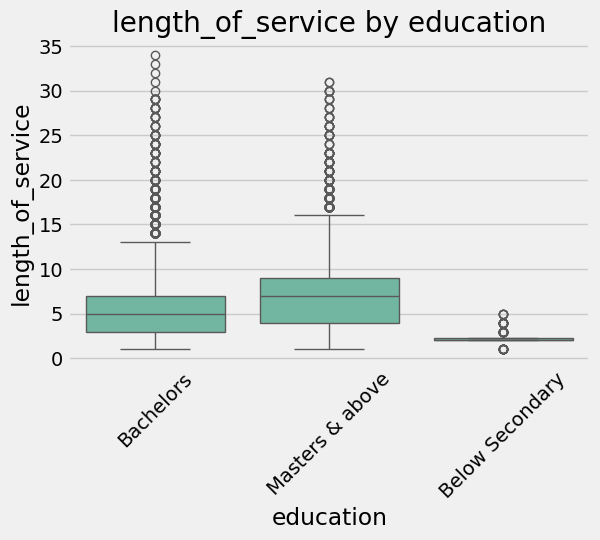

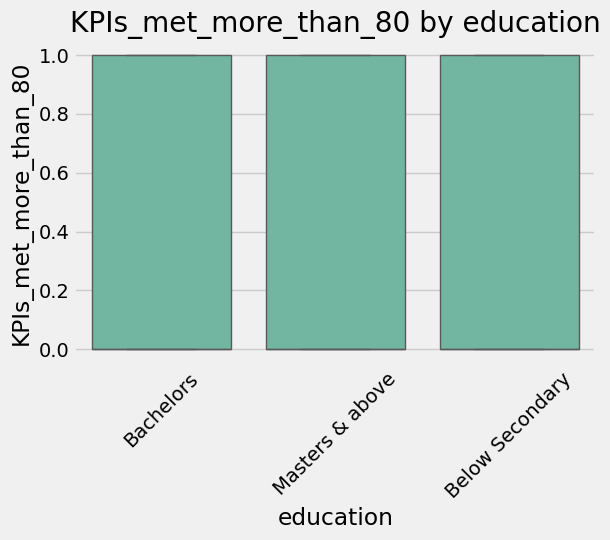

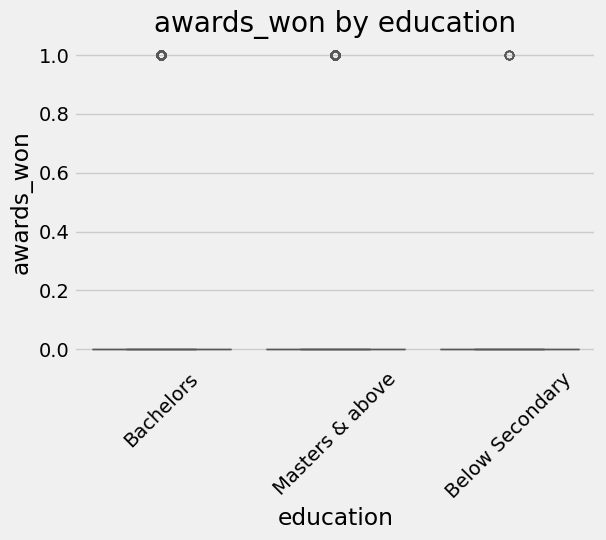

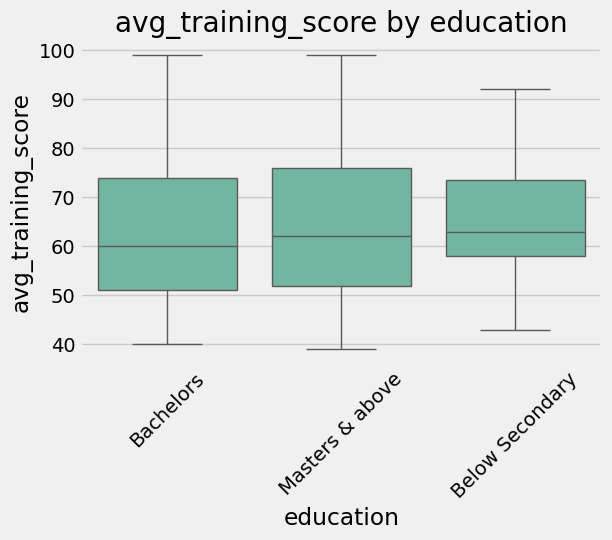

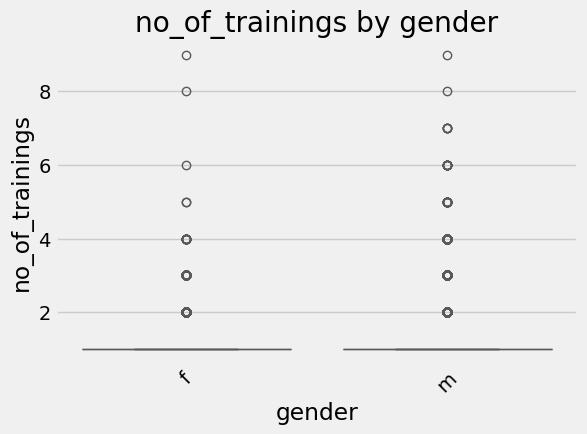

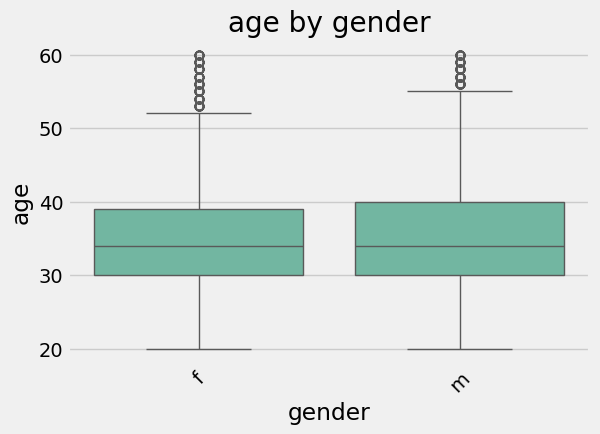

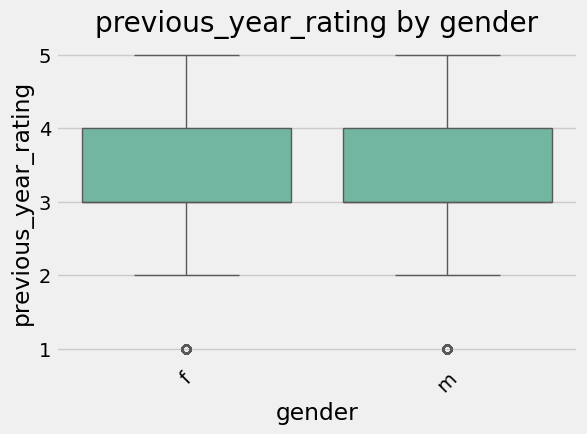

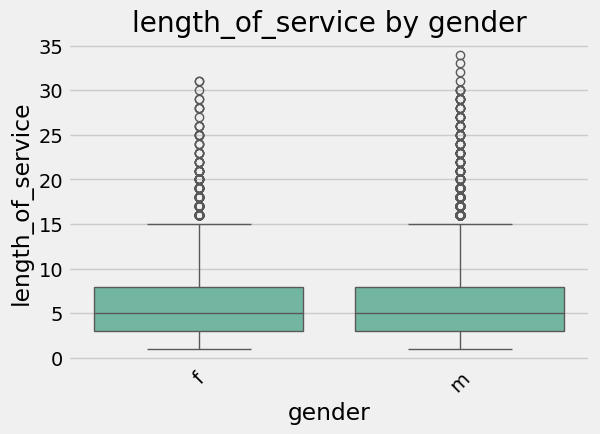

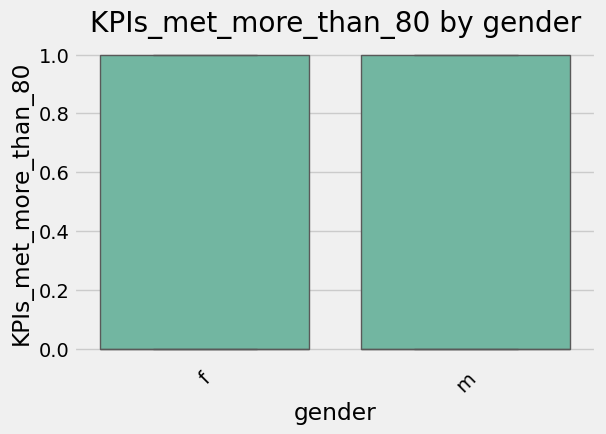

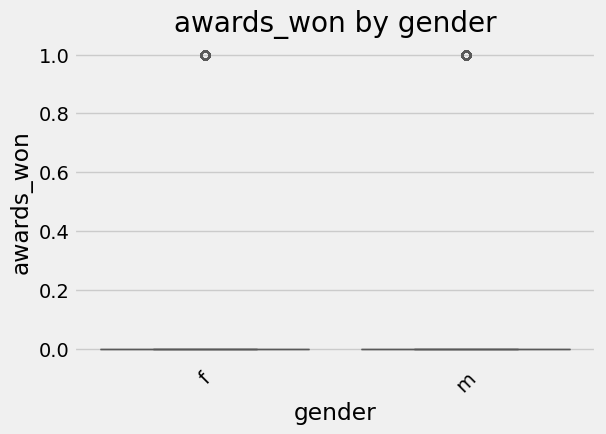

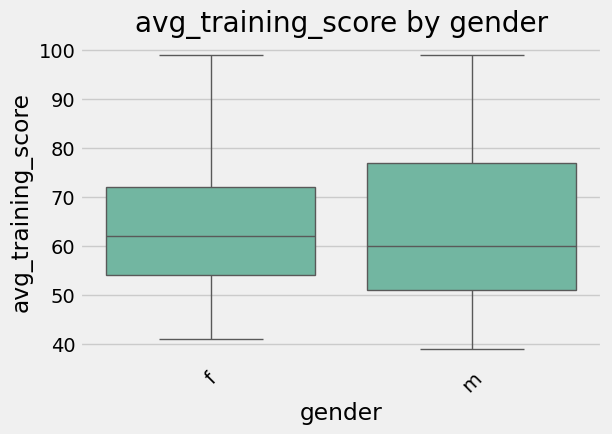

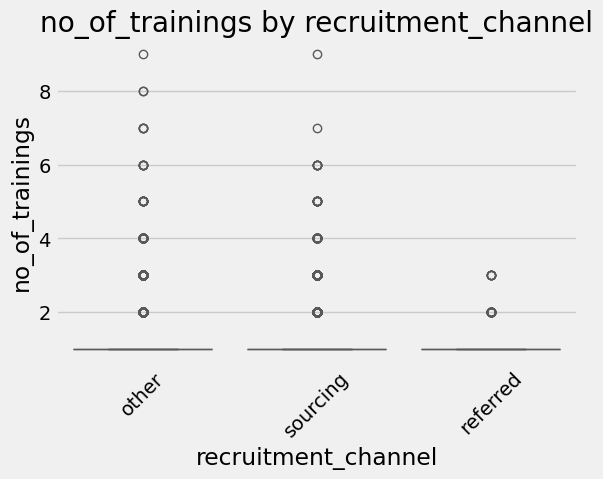

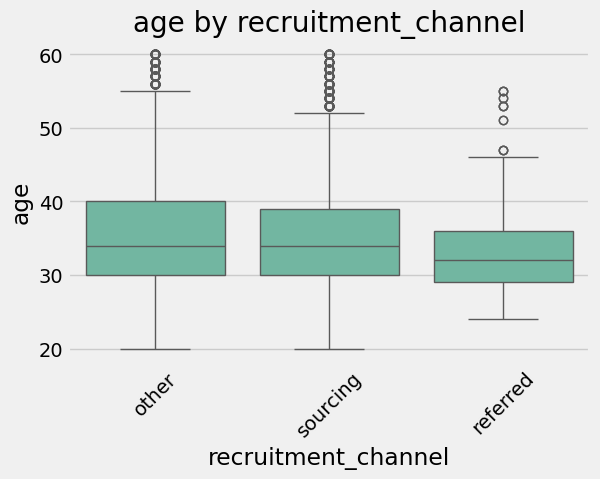

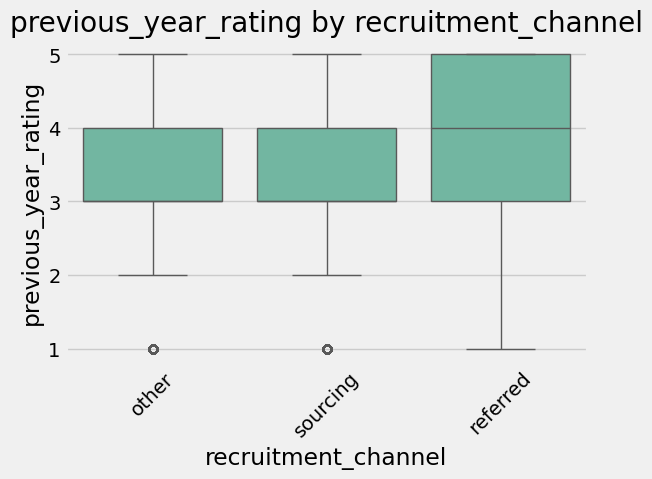

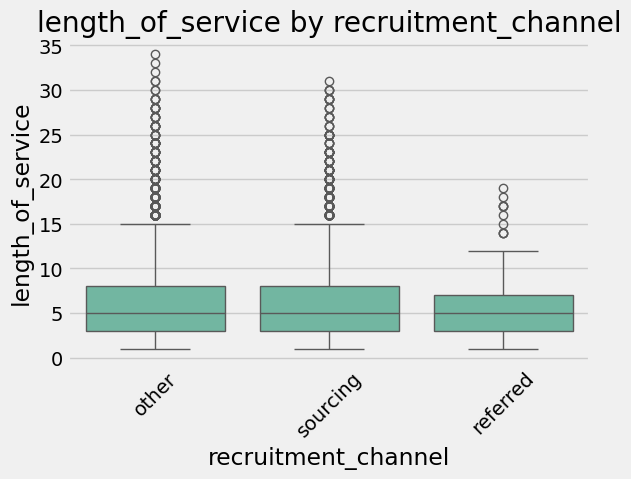

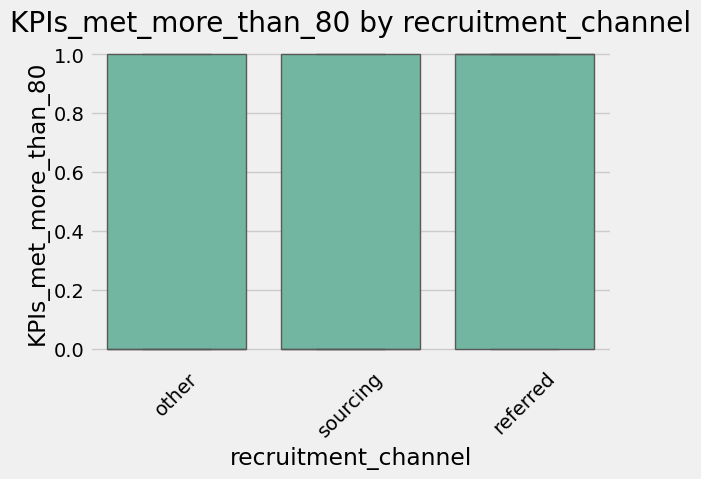

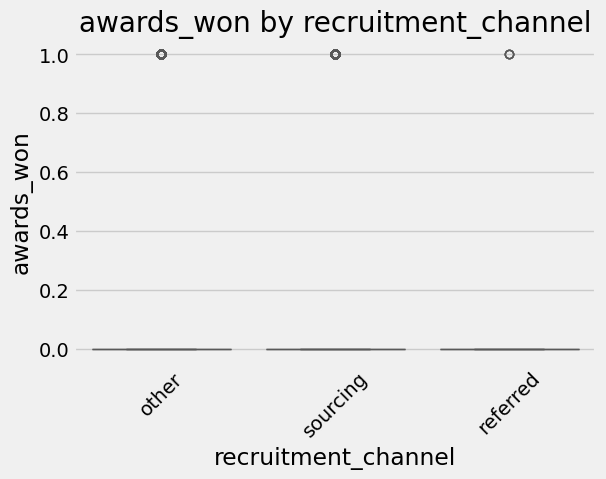

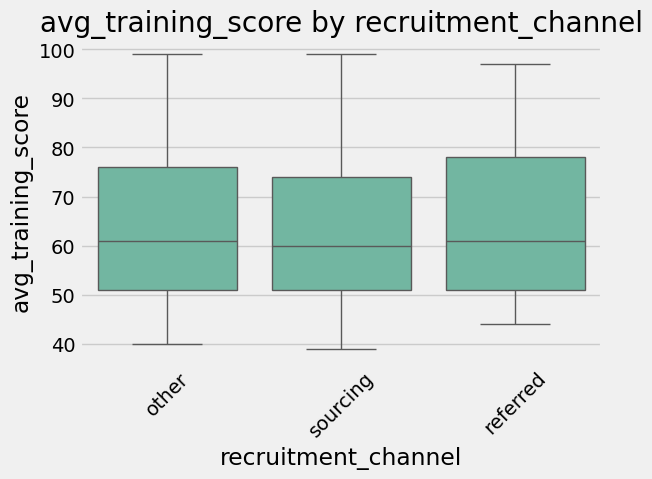

In [22]:
# Bivariate analysis
sns.pairplot(df[num_cols])
plt.show()

for cat in cat_cols:
    for num in num_cols:
        plt.figure(figsize=(6,4))
        sns.boxplot(x=cat, y=num, data=df)
        plt.title(f"{num} by {cat}")
        plt.xticks(rotation=45)
        plt.show()


### Correlation and Heatmap

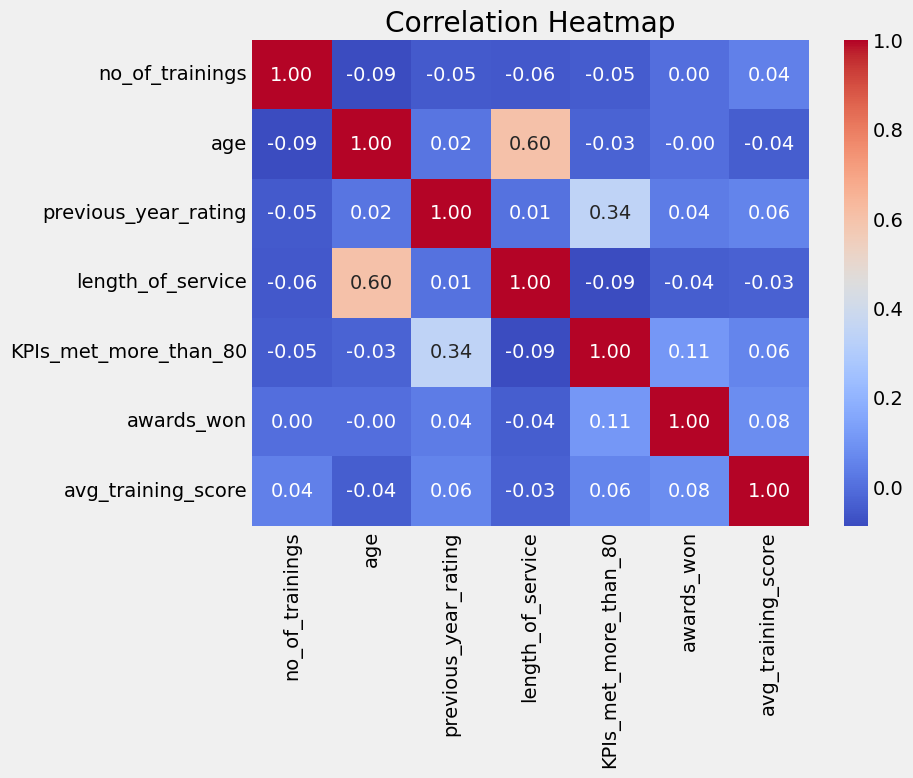

In [23]:
# Correlation Heatmap
corr = df[num_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

### Outlier Detection 

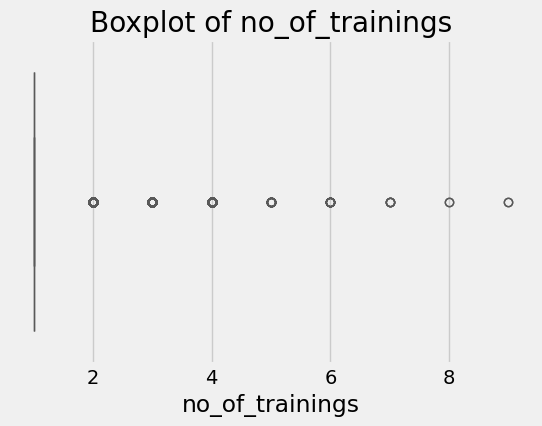

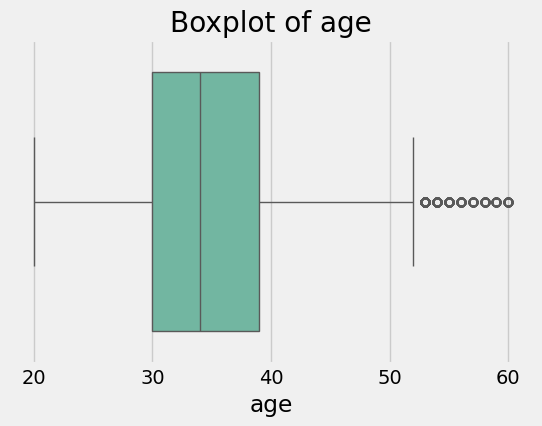

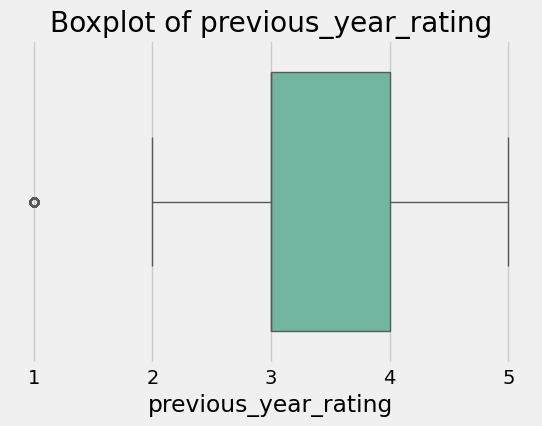

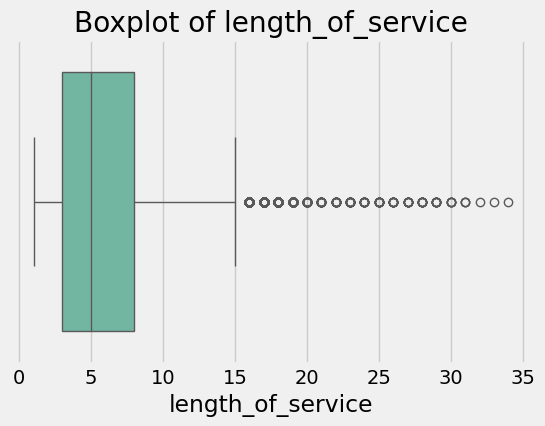

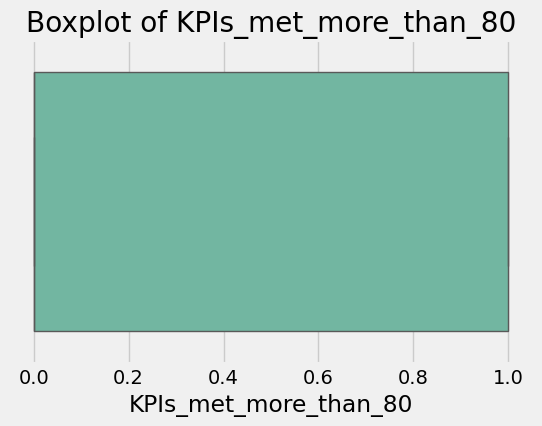

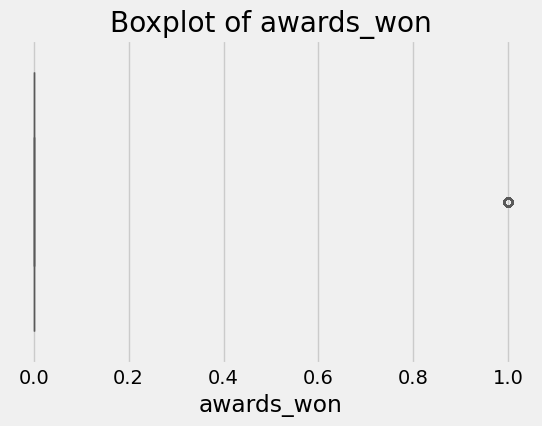

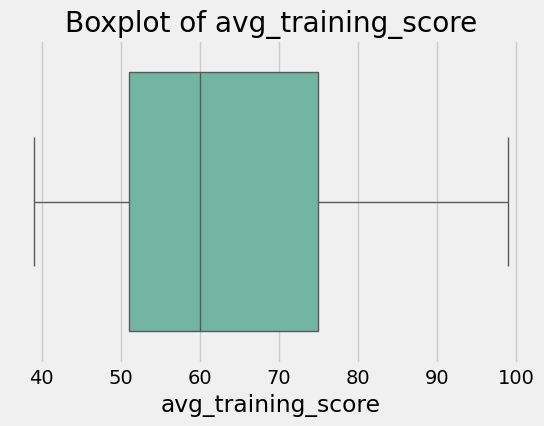

In [24]:
# Outlier Detection - Boxplots
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [25]:
# Remove outliers using IsolationForest
iso = IsolationForest(contamination=0.05, random_state=42)
outlier_pred = iso.fit_predict(df[num_cols])
mask_inliers = outlier_pred == 1
df_clean = df[mask_inliers].reset_index(drop=True)
print("Dataset Shape after Outlier Removal:", df_clean.shape)

Dataset Shape after Outlier Removal: (14650, 12)


###  Multicollinearity Check (Variance Inflation Factor - VIF)

In [26]:
# Multicollinearity check (VIF)
X = df[num_cols].copy()
X['intercept'] = 1
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data[vif_data['Feature'] != 'intercept']
display(vif_data)

,Feature,VIF
0,no_of_trainings,1.013519
1,age,1.576402
2,previous_year_rating,1.138775
3,length_of_service,1.582665
4,KPIs_met_more_than_80,1.158382
5,awards_won,1.019813
6,avg_training_score,1.014592


## Phase 5: Preprocessing


In [27]:
# numeric columns
num_cols = ['no_of_trainings', 'age', 'length_of_service', 'avg_training_score']  

# categorical columns
categorical_cols = [col for col in ['department','region','education','recruitment_channel'] if col in df.columns]

# numeric transformer with MinMaxScaler
numeric_transformer = Pipeline(steps=[
    ("scaler", MinMaxScaler()) 
])

# categorical transformer
categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore",  sparse_output=False))
])

# column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)
# Apply preprocessing
X_processed = preprocessor.fit_transform(df)

## Phase 6: Dimensionality Reduction (PCA)

In [28]:
pca = PCA(n_components=2, random_state=42)
principalComponents = pca.fit_transform(X_processed)
principalDf = pd.DataFrame(principalComponents, columns=['PC1','PC2'])

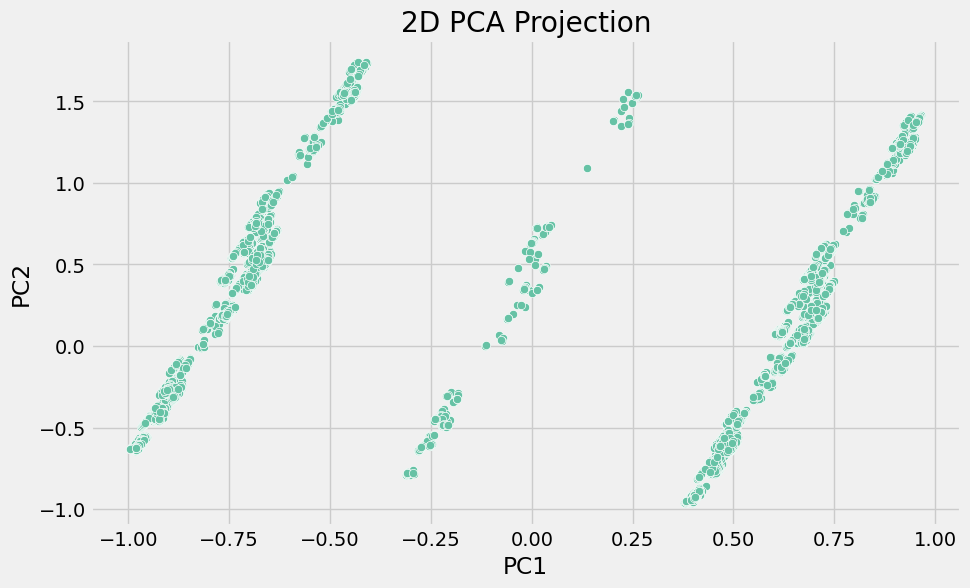

In [29]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='PC1', y='PC2', data=principalDf)
plt.title('2D PCA Projection')
plt.show()

## Phase 7: Clustering Models & Evaluation


In [30]:
# Evaluate clustering with multiple metrics
def evaluate_clustering(X, labels):
    return {
        "Silhouette": silhouette_score(X, labels),
        "Davies-Bouldin": davies_bouldin_score(X, labels),
        "Calinski-Harabasz": calinski_harabasz_score(X, labels)
    }

  **K-Means Clustering**


In [31]:
kmeans_results = []
for k in range(2,13):
    km = KMeans(n_clusters=k, random_state=42, n_init=50)
    km.fit(principalComponents)
    scores = evaluate_clustering(principalComponents, km.labels_)
    scores['k'] = k
    kmeans_results.append(scores)

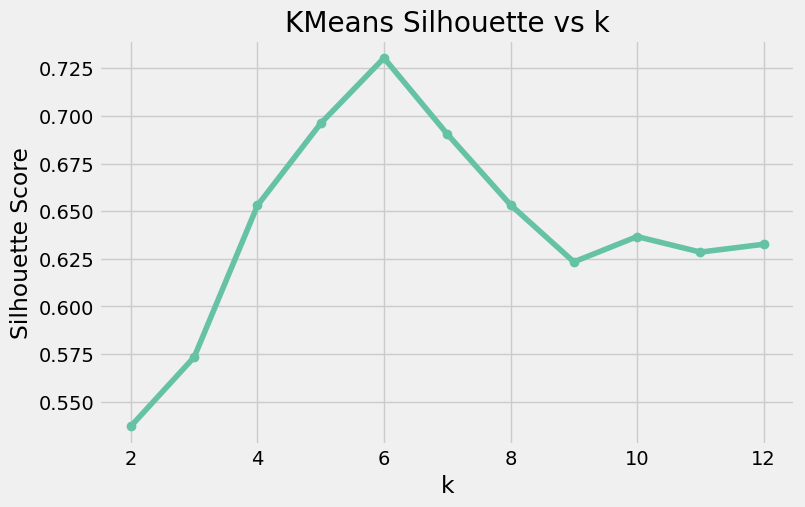

In [32]:
kmeans_df = pd.DataFrame(kmeans_results)
plt.figure(figsize=(8,5))
plt.plot(kmeans_df["k"], kmeans_df["Silhouette"], marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("KMeans Silhouette vs k")
plt.grid(True)
plt.show()

In [33]:
best_k = int(kmeans_df.sort_values("Silhouette", ascending=False).iloc[0]["k"])
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=50)
kmeans_labels = kmeans_final.fit_predict(principalComponents)
kmeans_scores = evaluate_clustering(principalComponents, kmeans_labels)


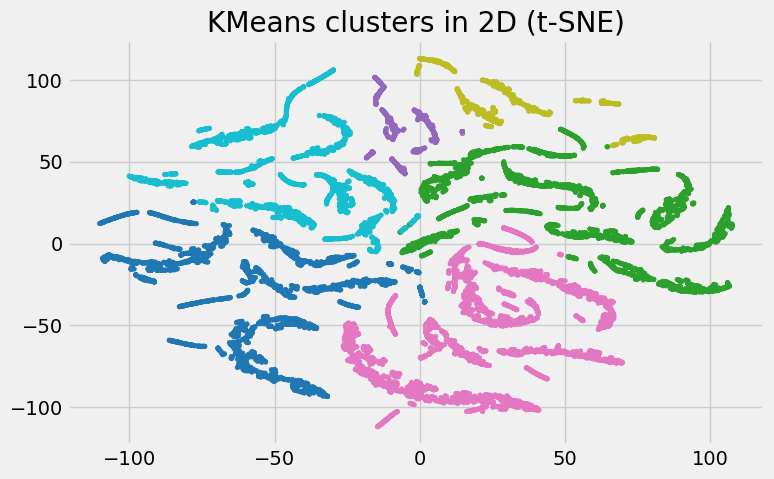

In [34]:
# KMeans t-SNE plot
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(principalComponents)
plt.figure(figsize=(8,5))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=kmeans_labels, cmap='tab10', s=10)
plt.title("KMeans clusters in 2D (t-SNE)")
plt.show()

**Hierarchical Clustering**

In [35]:
agg = AgglomerativeClustering(n_clusters=best_k, linkage='complete')
agg_labels = agg.fit_predict(principalComponents)
agg_scores = evaluate_clustering(principalComponents, agg_labels)
agg_scores


{'Silhouette': np.float64(0.6426319291069154),
 'Davies-Bouldin': np.float64(0.5062284847185387),
 'Calinski-Harabasz': np.float64(45349.423706214446)}

DBSCAN Clustering

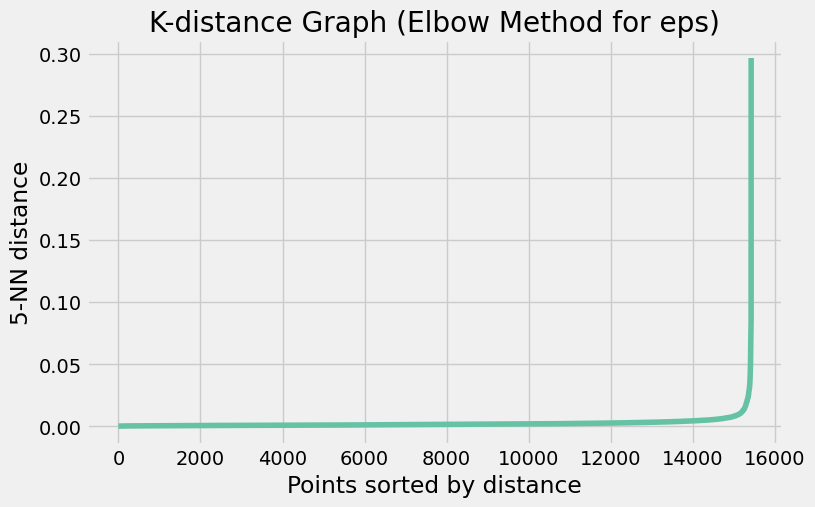

In [36]:
k = 5
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(principalComponents)
distances, indices = neighbors_fit.kneighbors(principalComponents)
k_distances = np.sort(distances[:, k-1])
plt.figure(figsize=(8,5))
plt.plot(k_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}-NN distance")
plt.title("K-distance Graph (Elbow Method for eps)")
plt.grid(True)
plt.show()

In [37]:
dbscan = DBSCAN(eps=0.6, min_samples=5)
labels = dbscan.fit_predict(principalComponents)
mask = labels != -1
score = silhouette_score(principalComponents[mask], labels[mask])
print(score)

0.3279680617896057


In [38]:
# DBSCAN t-SNE plot (inliers only)
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(principalComponents[mask])
plt.figure(figsize=(8,5))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=dbscan_labels[mask], cmap='tab10', s=15)
plt.title("DBSCAN clusters after removing noise")
plt.show()

NameError: name 'dbscan_labels' is not defined

<Figure size 800x500 with 0 Axes>

## Model Selection Summary


In [ ]:
# Compare clustering models and select the best
results = pd.DataFrame([
    {"Model": "KMeans", **kmeans_scores},
    {"Model": "Hierarchical", **agg_scores},
    {"Model": "DBSCAN", **dbscan_scores}
])
display(results)

,Model,Silhouette,Davies-Bouldin,Calinski-Harabasz
0,KMeans,0.730375,0.342848,64827.643591
1,Hierarchical,0.642632,0.506228,45349.423706
2,DBSCAN,0.327968,1.696561,7998.951973


## Phase 8: Model Saving


In [ ]:
# Save final pipeline including preprocessing, PCA, and best clustering model

# go up one directory from Notebooks/
MODEL_DIR = os.path.join("..", "Model")

os.makedirs(MODEL_DIR, exist_ok=True)

model_path = os.path.join(MODEL_DIR, "final_clustering_model.pkl")

final_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("pca", pca),
    ("clustering", kmeans_final)
])

joblib.dump(final_pipeline, model_path)
print(f"Final model saved at: {model_path}")


Final model saved at: ..\Model\final_clustering_model.pkl


#### Phase 5: Critical Analysis 